In [347]:

from help import unpickle
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib
import numpy as np
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from inspect import signature


# Import dataframes
M = unpickle('dataframe')
LF = unpickle('linear future')
EF = unpickle('exponential future')
FF = unpickle('facebook future')

In [348]:
def convert_date_to_number(start_date) -> int:
    '''
Return number of days since January 1, 2000
    '''
    end_date = datetime(2000,1,1)
    difference = start_date - end_date
    return difference.days

def convert_number_to_date(days_since):
    end_date = datetime(2000,1,1)
    return end_date + timedelta(days=days_since)
    

In [349]:
# make future array of dates
future_dates = [datetime(x, 12, 21) for x in range(2022, 2043)]
future_array = np.array([convert_date_to_number(x) for x in future_dates])

In [351]:
# define a linearizing function that get

def linearize(function, get, names):
    '''
function is any function

get is the string of the column that you want

names is a list of strings

example:


def cost_of_mea(X, m1, m2, b):
    # unpack variables
    dates, cost_of_crude = X
    # return function
    return m1*dates + m2*cost_of_crude + b

get = 'MEA Price China (USD:mt)'
dependencies = ['China Imports of Crude Petroleum (USD THO)','China Tianjin Water Price (USD:ton)']

constants, covariance, time_array, time_bool = linearize(cost_of_mea,get,dependencies)

# predict future

future_array = # numpy array, no index or columns
y_pred = cost_of_mea(future_array, *constants)
    '''

    sig = signature(function)

    if type(names) == type(list()):
        X = M[names].to_numpy()
    elif type(names) == type(pd.DataFrame()):
        X = names.to_numpy()
    else:
        X = names
    
    y = M[[get]].to_numpy().flatten()

    try:
        num_columns = X.shape[1]
    except:
        num_columns = 1

    if num_columns  > 1:
        # X is a multidimensional array
        bool_array = (np.isnan(X.sum(axis=1)) == False) & (np.isnan(y) == False)

        time_array = np.array([convert_date_to_number(i) for i in M.index[bool_array]])
        X = X[bool_array]
        y = y[bool_array]

        X = tuple([X[:,i] for i in range(X.shape[1])])

        start_constants = [0 for i in range(len(sig.parameters) - 1)]

    else:
        # it's only being compared to one thing
        X = X.flatten()

        bool_array = (np.isnan(X) == False) & (np.isnan(y) ==  False)

        time_array = np.array([convert_date_to_number(i) for i in M.index[bool_array]])
        X = X[bool_array]
        y = y[bool_array]

        start_constants = [0 for i in range(len(sig.parameters) - 1)]

    constants, covariance = scipy.optimize.curve_fit(function, X, y, p0=start_constants)

    # save plots of correctness
    
    constants = list(constants)

    y_pred = function(X, *constants)
    y_actual = M[get][bool_array]

    plt.title(get.replace(':',"/"))

    plt.plot(M.index[bool_array], y_pred, label = "predicted cost", color='red')
    plt.plot(M.index[bool_array], y_actual, label = "actual cost", color='blue')
    plt.legend()

    plt.savefig(f'{get} Backtest.png')

    # save plots for future extrapolation



    return constants, covariance, time_array, bool_array

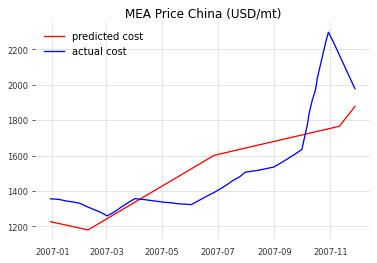

In [352]:
# Cost of monoethanolamine (MEA)

def cost_of_mea(cost_of_crude, m, b):
    return m*cost_of_crude + b

names = ['China Imports of Crude Petroleum (USD THO)'] #,'China Tianjin Water Price (USD:ton)'
get = 'MEA Price China (USD:mt)'

constants, covariance, time_array, time_bool = linearize(cost_of_mea,get,names)


In [353]:
constants

[0.00022445473915160628, 11.591748911387878]

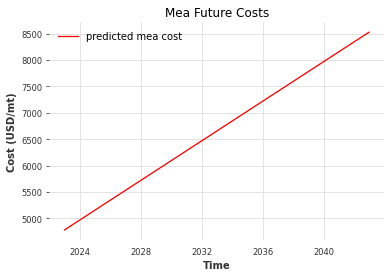

In [354]:
# Analysis of Extrapolation into the Future

future_china_petro = LF[['China Imports of Crude Petroleum (USD THO)']].to_numpy().flatten()

X = future_china_petro

y_pred = cost_of_mea(X, *constants)

plt.title("Mea Future Costs")
plt.xlabel("Time")
plt.ylabel("Cost (USD/mt)")

plt.plot(future_dates, y_pred, label = "predicted mea cost", color='red')
plt.legend()

# save for future reference
mea_future_cost = y_pred

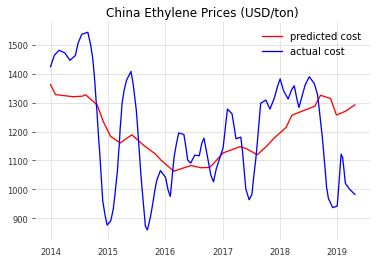

In [355]:
# Cost of Ethylene

def china_cost_of_ethylene(X, m1, m2, b):
    # unpack variables
    crude_oil_production, import_of_crude_oil = X
    # return function
    return m1*crude_oil_production + m2*import_of_crude_oil + b

get = 'China Ethylene Prices (USD:ton)'
dependencies = ['China Crude Oil Production (BBL:D:1K)','China Imports of Crude Petroleum (USD THO)']

constants, covariance, time_array, time_bool = linearize(china_cost_of_ethylene,get,dependencies)


In [356]:
constants

[0.16714252958655806, 2.2571585552790593e-05, 192.2412815336354]

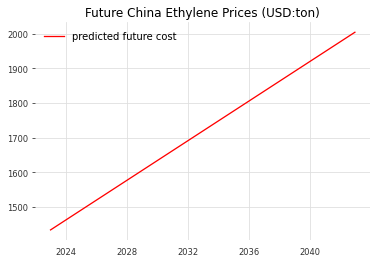

In [357]:
# predict future

future_array = LF[['China Crude Oil Production (BBL:D:1K)','China Imports of Crude Petroleum (USD THO)']].to_numpy()
future_array = tuple([future_array[:,i] for i in range(future_array.shape[1])])
y_pred = china_cost_of_ethylene(future_array, *constants)

plt.title('Future ' + get)
plt.xlabel("")
plt.ylabel("")

plt.plot(future_dates, y_pred, label = "predicted future cost", color='red')
plt.legend()


# save for future reference
ethylene_future_cost = y_pred

#ethylene_future_cost = EF[['China Ethylene Prices (USD:mt)']]


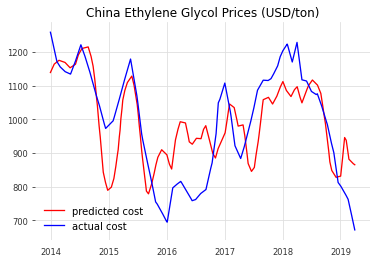

In [358]:
# Cost of Ethylene Glycol

def china_cost_of_ethylene_glycol(X, m, b):
    # unpack variables
    ethylene_glycol = X
    # return function
    return m*ethylene_glycol + b

get = 'China Ethylene Glycol Prices (USD:ton)'
dependencies = ['China Ethylene Prices (USD:ton)']

constants, covariance, time_array, time_bool = linearize(china_cost_of_ethylene_glycol,get,dependencies)

In [359]:
constants

[0.6404627257940895, 227.4215721996182]

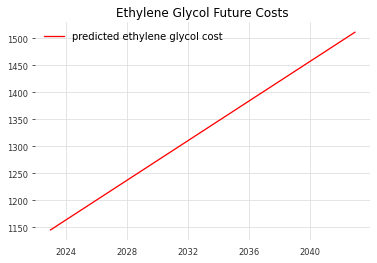

In [360]:
# predict future

future_array = ethylene_future_cost
y_pred = china_cost_of_ethylene_glycol(future_array, *constants)

plt.title("Ethylene Glycol Future Costs")
plt.xlabel("")
plt.ylabel("")

plt.plot(future_dates, y_pred, label = "predicted ethylene glycol cost", color='red')
plt.legend()

# save for future reference
ethylene_glycol_future_cost = y_pred

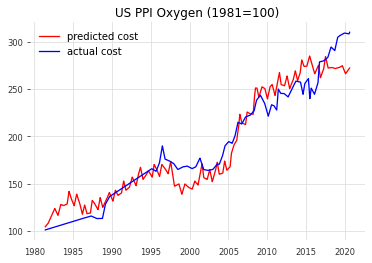

In [361]:
# Cost of Oxygen

def us_cost_of_oxygen(X, m, b):
    # unpack variables
    electricity_price = X
    # return function
    return m*electricity_price + b

get = 'US PPI Oxygen (1981=100)'
dependencies = ['CPI Price Data US Electricity $:kwh']

constants, covariance, time_array, time_bool = linearize(us_cost_of_oxygen,get,dependencies)


In [362]:
constants

[2538.4392040353496, -74.20247498001027]

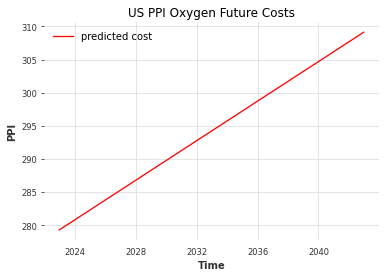

In [363]:
# predict future

future_array = FF[['CPI Price Data US Electricity $:kwh']].to_numpy().flatten()
y_pred = china_cost_of_ethylene_glycol(future_array, *constants)

plt.title("US PPI Oxygen Future Costs")
plt.xlabel("Time")
plt.ylabel("PPI")

plt.plot(future_dates, y_pred, label = "predicted cost", color='red')
plt.legend()

# save for future reference
oxygen_future_cost = y_pred

In [364]:
# Cost of Water
'''
def china_tianjin_precipitation(X, m, b):
    date = X
    return m*date + b

get = 'Tianjin Precip (mm)'
dependencies = np.array([convert_date_to_number(x) for x in M.index])

constants, covariance, time_array, time_bool = linearize(china_tianjin_precipitation,get,dependencies)

precipitation_tianjin_future = china_tianjin_precipitation(future_array, *constants)
precipitation_tianjin_smooth = china_tianjin_precipitation(time_array, *constants)
'''

"\ndef china_tianjin_precipitation(X, m, b):\n    date = X\n    return m*date + b\n\nget = 'Tianjin Precip (mm)'\ndependencies = np.array([convert_date_to_number(x) for x in M.index])\n\nconstants, covariance, time_array, time_bool = linearize(china_tianjin_precipitation,get,dependencies)\n\nprecipitation_tianjin_future = china_tianjin_precipitation(future_array, *constants)\nprecipitation_tianjin_smooth = china_tianjin_precipitation(time_array, *constants)\n"

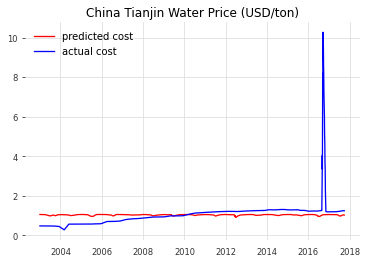

In [365]:

def china_tianjin_water_price(X, m, b):
    precipitation = X
    return m*precipitation + b

get = 'China Tianjin Water Price (USD:ton)'
precip_df = M[['Tianjin Precip (mm)']].copy()
dependencies = precip_df.replace(precip_df[time_bool], pd.Series(precipitation_tianjin_smooth))

constants, covariance, time_array, time_bool = linearize(china_tianjin_water_price,get,dependencies)


In [366]:
# TODO: Try to match precipitation in Tianjin to China's inflation
'''
dependencies = ['Korea Monthly Precip in mm/day']
constants, covariance, time_array, time_bool = linearize(china_tianjin_water_price,get,dependencies)
'''

"\ndependencies = ['Korea Monthly Precip in mm/day']\nconstants, covariance, time_array, time_bool = linearize(china_tianjin_water_price,get,dependencies)\n"

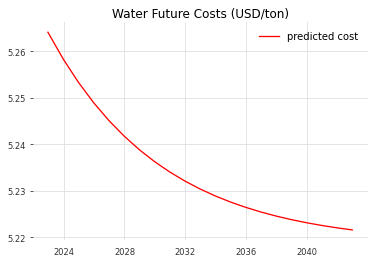

In [367]:
# Cost of cooling water

water_future_cost = EF[['Cooling Water US (cents:m^3)']].to_numpy()

plt.title("Water Future Costs (USD/ton)")
plt.xlabel("")
plt.ylabel("")

plt.plot(future_dates, water_future_cost, label = "predicted cost", color='red')
plt.legend()

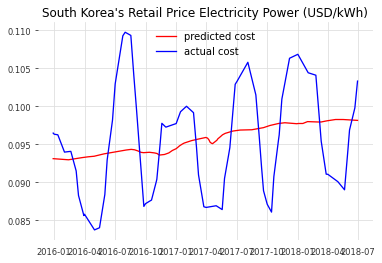

In [378]:
# Cost of Electricity

def electricity_sk_cost(X, m1, m2, b):
    cost_of_lng, cost_of_coal= X
    return m1*cost_of_lng + m2*cost_of_coal + b
'''
def electricity_sk_cost(X, m, b):
    cost_of_coal= X
    return m*cost_of_coal + b
'''
get = "South Korea's Retail Price Electricity Power (USD:kWh)"
dependencies = ['LNG import prices Japan (USD:million Btu)','Austrailian Coal (USD:tonne)']
# dependencies = ['Austrailian Coal (USD:tonne)']
constants, covariance, time_array, time_bool = linearize(electricity_sk_cost,get,dependencies)

# it looks like it's ahead by half a year

electricity_future_cost = FF[["South Korea's Retail Price Electricity Power (USD:kWh)"]].to_numpy().flatten()

In [379]:
constants

[0.002843832428690096, -7.54893798536063e-06, 0.07317650144792709]

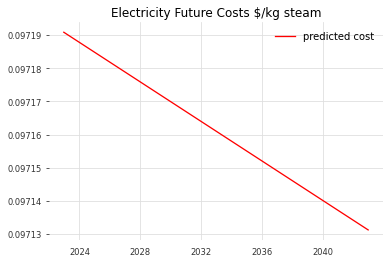

In [369]:
# plot future

plt.title("Electricity Future Costs $/kg steam")
plt.xlabel("")
plt.ylabel("")

plt.plot(future_dates, electricity_future_cost, label = "predicted cost", color='red')
plt.legend()

In [370]:
# Cost of Steam (USD / kg)
# Used formula from:
# https://terpconnect.umd.edu/~NSW/chbe446/HowToEstimateUtilityCosts-UlrichVasudevan2006.pdf
# Cs = 2.7*10^-5* * (CE PCI) + b * (cost of fuel (USD / GJ))

def cost_of_steam(X, steam_needed, pressure_needed):
    ce_pci = X
    cost_of_lng = .75 / 1.055 # (USD / GJ)
    a = 2.7*10**(-5)  *  steam_needed**(-9)
    b = 0.0034 * pressure_needed**0.05
    return a * ce_pci + b * cost_of_lng

steam_needed = 349.1399629 # kg/s
pressure_needed = 42 # barg
# fix index
FF.index = LF.index
dependencies = LF[['CE Plant Cost Index']]
dependencies = dependencies.to_numpy()
#dependencies = tuple([dependencies[:,i] for i in range(dependencies.shape[1])])

steam_future_cost = cost_of_steam(dependencies, steam_needed, pressure_needed)


In [371]:
'''
def cost_of_steam(X, m, b):
    cooling_water = X
    return m*cooling_water + b


get = 'Steam US (USD:mt)'
dependencies = ['Cooling Water US (cents:m^3)']

constants, covariance, time_array, time_bool = linearize(us_cost_of_oxygen,get,dependencies)
'''

"\ndef cost_of_steam(X, m, b):\n    cooling_water = X\n    return m*cooling_water + b\n\n\nget = 'Steam US (USD:mt)'\ndependencies = ['Cooling Water US (cents:m^3)']\n\nconstants, covariance, time_array, time_bool = linearize(us_cost_of_oxygen,get,dependencies)\n"

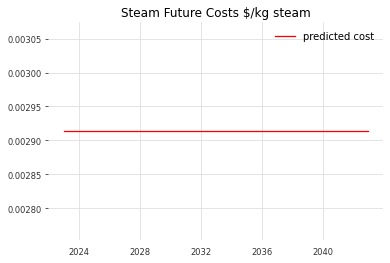

In [372]:
# plot future

plt.title("Steam Future Costs $/kg steam")
plt.xlabel("")
plt.ylabel("")

plt.plot(future_dates, steam_future_cost, label = "predicted cost", color='red')
plt.legend()

In [373]:
FINAL = pd.concat([pd.DataFrame(mea_future_cost),
                   pd.DataFrame(ethylene_future_cost),
                   pd.DataFrame(ethylene_glycol_future_cost),
                   pd.DataFrame(oxygen_future_cost),
                   pd.DataFrame(water_future_cost),
                   pd.DataFrame(electricity_future_cost),
                   pd.DataFrame(steam_future_cost)],axis=1)

In [374]:
FINAL

,0,0,0,0,0,0,0
0,4783.440016,1432.997542,1145.203084,279.295270,5.264069,0.097191,0.002914
1,4970.415215,1461.568755,1163.501881,280.785701,5.258347,0.097188,0.002914
2,5157.902675,1490.218246,1181.850812,282.280215,5.253331,0.097185,0.002914
3,5344.877875,1518.789460,1200.149610,283.770645,5.248958,0.097182,0.002914
4,5531.853074,1547.360673,1218.448407,285.261076,5.245134,0.097179,0.002914
5,5718.828274,1575.931887,1236.747204,286.751507,5.241791,0.097176,0.002914
6,5906.315734,1604.581378,1255.096135,288.246020,5.238859,0.097173,0.002914
7,6093.290934,1633.152592,1273.394933,289.736451,5.236304,0.097170,0.002914
8,6280.266133,1661.723805,1291.693730,291.226882,5.234069,0.097167,0.002914
9,6467.241332,1690.295019,1309.992527,292.717312,5.232116,0.097164,0.002914


In [375]:
FINAL.index  = LF.index
FINAL.columns = ['China MEA Price (USD/mt)',
                 'China Ethylene Prices (USD/ton)',
                 'China Ethylene Glycol Prices (USD/ton)',
                 'US PPI Oxygen (1981=100)',
                 'Cooling Water US (cents:m^3)',
                 "South Korea's Retail Price Electricity Power (USD/kWh)",
                 'US Steam Future Costs (USD/kg)']

In [376]:
FINAL.to_csv('projected prices.csv')

In [377]:
EF[['Steam US HP (USD:mt)','Steam US MP (USD:mt)','Steam US LP (USD:mt)']]

,Steam US HP (USD:mt),Steam US MP (USD:mt),Steam US LP (USD:mt)
2022-12-31,29.030352,26.610720,25.371146
2023-12-31,29.024712,26.605059,25.365499
2024-12-31,29.019773,26.600099,25.360552
2025-12-31,29.015471,26.595778,25.356243
2026-12-31,29.011712,26.592002,25.352478
2027-12-31,29.008429,26.588702,25.349189
2028-12-31,29.005553,26.585811,25.346308
2029-12-31,29.003048,26.583293,25.343798
2030-12-31,29.000860,26.581092,25.341605
2031-12-31,28.998948,26.579169,25.339689
